# Lab 7: Implementing Object Detection with YOLO for Telecom Infrastructure

**Objective**
This lab focuses on implementing object detection for telecom infrastructure using YOLOv8. Students will learn to train and deploy a YOLO model for detecting different types of antennas (GSM and Microwave) in real-world scenarios. The lab demonstrates practical applications of object detection in the telecommunications industry, covering model training, evaluation, and inference on new images.

**Dataset Information**


Source: [Tower Detection Dataset](https://universe.roboflow.com/object-detection-yolo-c8gsd/tower-detection-tff1p)


Classes: 3 types of antennas

- GSM Antenna
- GSM Antenna (variant)
- Microwave Antenna


**Dataset Split**

- Training: 1350 images (99%)
- Validation: 7 images (1%)
- Testing: 5 images

#Tasks Overview


1.   Environment Setup and Dependencies Installation
2.   Dataset Download and Preparation
3.   YOLOv8 Model Configuration
4.   Model Training
5.   Performance Evaluation
6.   Inference on Test Images
7.   Model Export

# Task 1: Environment Setup and Dependencies Installation

In [1]:
# Install required packages
!pip install ultralytics
!pip install roboflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
# Import necessary libraries
import ultralytics
from ultralytics import YOLO
from roboflow import Roboflow
import os
import cv2
import numpy as np
from google.colab import drive

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Task 2: Dataset Download and Preparation

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set working directory
import os
%cd /content

Mounted at /content/drive
/content


**Setup Data path**

In [4]:
# Define dataset path (update this to your Google Drive path)
DATASET_PATH = '/content/drive/MyDrive/tower_dataset'  # Update this path

# Verify dataset structure
!ls {DATASET_PATH}

# Display data.yaml content
!cat {DATASET_PATH}/data.yaml

# Setup directory structure
train_path = os.path.join(DATASET_PATH, 'train/images')
valid_path = os.path.join(DATASET_PATH, 'valid/images')
test_path = os.path.join(DATASET_PATH, 'test/images')

# Verify image counts
print(f"Training images: {len(os.listdir(train_path))}")
print(f"Validation images: {len(os.listdir(valid_path))}")
print(f"Test images: {len(os.listdir(test_path))}")

best.pt  data.yaml  test  train  valid
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['GSM Antenna', 'GSM Antenna ', 'Microwave Antenna']

roboflow:
  workspace: object-detection-yolo-c8gsd
  project: tower-detection-tff1p
  version: 3
  license: CC BY 4.0
  url: https://universe.roboflow.com/object-detection-yolo-c8gsd/tower-detection-tff1p/dataset/3Training images: 1350
Validation images: 7
Test images: 5


Data Visualization

Sample Training Images:


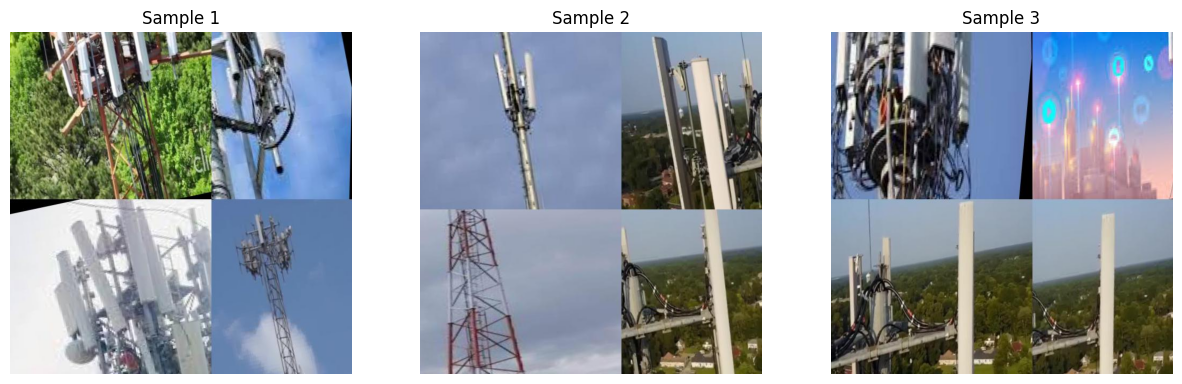

In [5]:
import matplotlib.pyplot as plt
import random

def display_sample_images(image_path, num_samples=3):
    """Display random sample images from the dataset"""
    images = os.listdir(image_path)
    samples = random.sample(images, num_samples)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(samples, 1):
        img = cv2.imread(os.path.join(image_path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i)
        plt.imshow(img)
        plt.title(f'Sample {i}')
        plt.axis('off')
    plt.show()

# Display sample training images
print("Sample Training Images:")
display_sample_images(train_path)

# Task 3: YOLOv8 Model Configuration

In [6]:
import torch

# Check CUDA availability
print(f"CUDA is available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"CUDA Version: {torch.version.cuda}")

CUDA is available: True
CUDA Device: Tesla T4
Number of CUDA devices: 1
CUDA Version: 12.1


In [7]:
# Load a pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')

# Move model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")

# Display model information
print("\nModel Information:")
print(model.info())

# Display model parameters
print(f"\nTotal Parameters: {sum(p.numel() for p in model.parameters())}")

100%|██████████| 6.25M/6.25M [00:00<00:00, 362MB/s]



Using device: cuda

Model Information:
YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs
(225, 3157200, 0, 8.8575488)

Total Parameters: 3157200


#Task 4: Model Training


 Configure Training Parameters

In [11]:
# Define training configuration
train_config = {
    'data': os.path.join(DATASET_PATH, 'data.yaml'),
    'epochs': 50,
    'imgsz': 640,
    'batch': 32,
    'name': 'tower_detection_model',
    'patience': 20,         # Early stopping patience
    'save': True,          # Save best model
    'device': 0 if torch.cuda.is_available() else 'cpu',  # Use GPU if available
    'workers': 8,          # Number of worker threads
    'optimizer': 'Adam',   # Optimizer (SGD, Adam, AdamW)
    'lr0': 0.01,          # Initial learning rate
    'weight_decay': 0.0005,# Weight decay
    'exist_ok': True,      # Overwrite existing experiment
    'pretrained': True,    # Use pretrained backbone
    'amp': True,          # Automatic Mixed Precision
}

# Adjust batch size based on available GPU memory
if torch.cuda.is_available():
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9  # Memory in GB
    print(f"\nGPU Memory Available: {gpu_mem:.2f} GB")

    # Adjust batch size based on GPU memory
    if gpu_mem < 8:
        train_config['batch'] = 8
    elif gpu_mem < 16:
        train_config['batch'] = 16
    else:
        train_config['batch'] = 32

print("\nTraining Configuration:")
for key, value in train_config.items():
    print(f"{key}: {value}")


GPU Memory Available: 15.84 GB

Training Configuration:
data: /content/drive/MyDrive/tower_dataset/data.yaml
epochs: 50
imgsz: 640
batch: 16
name: tower_detection_model
patience: 20
save: True
device: 0
workers: 8
optimizer: Adam
lr0: 0.01
weight_decay: 0.0005
exist_ok: True
pretrained: True
amp: True


Start Training

In [12]:
# Start training with configured parameters
results = model.train(**train_config)

# Save training results
model.save(os.path.join(DATASET_PATH, 'best.pt'))

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/tower_dataset/data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=tower_detection_model, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

train: Scanning /content/drive/MyDrive/tower_dataset/train/labels.cache... 1350 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1350/1350 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 3201, len(boxes) = 16080. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/tower_dataset/valid/labels.cache... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<?, ?it/s]


Plotting labels to runs/detect/tower_detection_model/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/tower_detection_model
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.71G      2.196      2.184      1.908        123        640: 100%|██████████| 85/85 [00:47<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

                   all          7         21      0.501      0.225      0.305      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       3.1G       2.16       2.09      1.968         99        640: 100%|██████████| 85/85 [00:35<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all          7         21      0.424        0.1      0.113     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.93G      2.121      2.081       1.95        170        640: 100%|██████████| 85/85 [00:34<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all          7         21      0.214      0.125      0.112     0.0553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.93G      2.065      2.032      1.908         55        640: 100%|██████████| 85/85 [00:36<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all          7         21      0.298      0.163      0.149     0.0527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.07G      2.021      1.969      1.884         64        640: 100%|██████████| 85/85 [00:34<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all          7         21      0.503      0.194      0.171      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.81G      2.004      1.989      1.889         64        640: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all          7         21      0.564      0.163      0.162       0.07



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.18G      1.973      1.932       1.84        121        640: 100%|██████████| 85/85 [00:35<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all          7         21      0.663      0.191      0.232     0.0858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.78G      1.955      1.936       1.84        127        640: 100%|██████████| 85/85 [00:33<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all          7         21       0.71      0.225      0.292      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.89G      1.912      1.909      1.834         44        640: 100%|██████████| 85/85 [00:32<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all          7         21       0.39      0.294      0.325      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.98G      1.894      1.824      1.774         81        640: 100%|██████████| 85/85 [00:32<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

                   all          7         21      0.652      0.276       0.39      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.06G      1.917      1.879      1.803         65        640: 100%|██████████| 85/85 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all          7         21      0.748      0.241       0.28     0.0759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.08G      1.876      1.824      1.778         73        640: 100%|██████████| 85/85 [00:35<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


                   all          7         21      0.702      0.292      0.404      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.03G      1.877      1.811      1.767         84        640: 100%|██████████| 85/85 [00:35<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all          7         21      0.403      0.265      0.258      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.73G      1.865      1.807       1.76        114        640: 100%|██████████| 85/85 [00:35<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all          7         21      0.388      0.194      0.285      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.82G      1.845      1.761      1.748        124        640: 100%|██████████| 85/85 [00:35<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all          7         21      0.352      0.394      0.361      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.32G       1.84      1.765      1.748         89        640: 100%|██████████| 85/85 [00:31<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all          7         21      0.733      0.289      0.404      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.12G      1.812      1.764      1.733         92        640: 100%|██████████| 85/85 [00:33<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

                   all          7         21      0.252      0.594      0.457      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.11G      1.817      1.745      1.733         86        640: 100%|██████████| 85/85 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all          7         21      0.836      0.277      0.481        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.98G      1.801      1.703      1.707        108        640: 100%|██████████| 85/85 [00:34<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all          7         21      0.721       0.25      0.416      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.9G      1.824      1.738      1.735         88        640: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all          7         21      0.875      0.263      0.439      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.95G      1.806      1.732      1.735        100        640: 100%|██████████| 85/85 [00:35<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


                   all          7         21      0.719      0.324      0.433      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.82G      1.789      1.668      1.699        165        640: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all          7         21      0.899      0.311      0.408      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       3.1G      1.804      1.728      1.733        114        640: 100%|██████████| 85/85 [00:35<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all          7         21      0.832      0.394      0.494      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.02G      1.773      1.686       1.71         96        640: 100%|██████████| 85/85 [00:33<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all          7         21      0.764      0.414      0.547      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         3G      1.782      1.665      1.696        111        640: 100%|██████████| 85/85 [00:32<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all          7         21      0.657      0.506      0.519      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.46G      1.772      1.659      1.705        117        640: 100%|██████████| 85/85 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all          7         21      0.409      0.656      0.541      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.81G       1.77      1.674      1.695        109        640: 100%|██████████| 85/85 [00:32<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all          7         21      0.742       0.39       0.43      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.94G      1.751      1.618       1.67        128        640: 100%|██████████| 85/85 [00:33<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


                   all          7         21      0.779      0.425      0.588      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.26G      1.744      1.632      1.668         87        640: 100%|██████████| 85/85 [00:34<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all          7         21      0.396      0.478      0.459      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.78G      1.725      1.616       1.66        131        640: 100%|██████████| 85/85 [00:34<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all          7         21      0.755      0.386      0.563      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.67G      1.733      1.589      1.656        172        640: 100%|██████████| 85/85 [00:34<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]

                   all          7         21      0.887      0.293      0.484      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.11G      1.742      1.636      1.681         88        640: 100%|██████████| 85/85 [00:32<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all          7         21      0.679      0.301      0.453      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.41G      1.718      1.607       1.66         73        640: 100%|██████████| 85/85 [00:38<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all          7         21      0.787      0.394      0.604       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.97G       1.72      1.613      1.664         83        640: 100%|██████████| 85/85 [00:32<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


                   all          7         21      0.576      0.467      0.462      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.21G      1.698      1.565      1.641        179        640: 100%|██████████| 85/85 [00:31<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all          7         21      0.518      0.656      0.601      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.96G      1.699      1.536      1.625        126        640: 100%|██████████| 85/85 [00:33<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all          7         21      0.381      0.664      0.551      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.92G      1.706      1.568      1.635        180        640: 100%|██████████| 85/85 [00:33<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all          7         21       0.68      0.549      0.629      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.04G      1.687      1.545      1.626        124        640: 100%|██████████| 85/85 [00:33<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

                   all          7         21      0.713      0.553      0.621      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.9G      1.681      1.525      1.616        176        640: 100%|██████████| 85/85 [00:34<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all          7         21      0.746      0.656       0.75      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.38G      1.679      1.532      1.625        109        640: 100%|██████████| 85/85 [00:32<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all          7         21      0.493      0.719      0.605      0.301


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.58G      1.705      1.514      1.664         57        640: 100%|██████████| 85/85 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all          7         21        0.8      0.464      0.603      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.56G      1.679      1.476      1.648         76        640: 100%|██████████| 85/85 [00:29<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all          7         21      0.891      0.505      0.671      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.54G       1.68      1.462      1.651         59        640: 100%|██████████| 85/85 [00:32<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

                   all          7         21          1      0.421      0.722      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.59G      1.672      1.448       1.65         69        640: 100%|██████████| 85/85 [00:33<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]


                   all          7         21      0.814      0.525      0.663      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.58G      1.672      1.441      1.644         59        640: 100%|██████████| 85/85 [00:32<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all          7         21      0.607      0.699      0.717      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.59G      1.638      1.406      1.616         71        640: 100%|██████████| 85/85 [00:30<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


                   all          7         21      0.814       0.58      0.723      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.59G      1.634      1.409      1.617         54        640: 100%|██████████| 85/85 [00:30<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all          7         21      0.945       0.53      0.733      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.58G       1.61      1.388      1.606         54        640: 100%|██████████| 85/85 [00:33<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

                   all          7         21      0.621      0.727      0.702      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.61G      1.605       1.37      1.593         77        640: 100%|██████████| 85/85 [00:36<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all          7         21      0.679      0.688      0.709      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.57G      1.583      1.365      1.594         97        640: 100%|██████████| 85/85 [00:30<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all          7         21       0.59      0.688      0.677      0.321



50 epochs completed in 0.503 hours.
Optimizer stripped from runs/detect/tower_detection_model/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/tower_detection_model/weights/best.pt, 6.2MB

Validating runs/detect/tower_detection_model/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


                   all          7         21      0.749      0.656       0.75      0.402
           GSM Antenna          6         16      0.721      0.312      0.505       0.18
     Microwave Antenna          4          5      0.778          1      0.995      0.624
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/tower_detection_model


# Task 5: Performance Evaluation

In [13]:
# Plot training metrics
from ultralytics.utils.plotting import plot_results



# Plot the results using the static method
plot_results(file='/content/runs/detect/tower_detection_model/results.png')  # plot results.txt as results.png
plt.show()

# Display final metrics
print("\nTraining Results:")

# Load and display metrics from results.csv
import pandas as pd
try:
    results_df = pd.read_csv('/content/runs/detect/tower_detection_model/results.csv')
    print("\nFinal Metrics:")
    print(f"Best mAP50: {results_df['metrics/mAP50(B)'].max():.4f}")
    print(f"Best mAP50-95: {results_df['metrics/mAP50-95(B)'].max():.4f}")
    print(f"Final Epoch: {len(results_df)}")
except Exception as e:
    print(f"Could not load results.csv: {e}")



Training Results:

Final Metrics:
Best mAP50: 0.7504
Best mAP50-95: 0.4021
Final Epoch: 50


 Performance Evaluation

In [14]:
# Validate the model
metrics = model.val()

# Display metrics
print(f"mAP50: {metrics.box.map50}")
print(f"mAP50-95: {metrics.box.map}")

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/tower_dataset/valid/labels.cache... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


                   all          7         21      0.644      0.656        0.7      0.365
           GSM Antenna          6         16      0.658      0.312      0.505      0.179
     Microwave Antenna          4          5      0.631          1      0.895      0.552
Speed: 0.3ms preprocess, 16.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/tower_detection_model
mAP50: 0.699988939680277
mAP50-95: 0.36516746670420464


# Task 6: Inference on Test Images


In [16]:
def predict_image(image_path):
    # Perform prediction
    results = model.predict(image_path, conf=0.25)

    # Process and display results
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Get coordinates and class
            x1, y1, x2, y2 = box.xyxy[0]
            cls = box.cls
            conf = box.conf

            # print(f"Detected {model.names[int(cls)]} with confidence {conf:.2f}")

    return results[0].plot()

# Test on sample image
test_image = "/content/drive/MyDrive/tower_dataset/test/images/MP_3_jpeg.rf.7bded774087bd0b184d65eb93ce0eb04.jpg"
prediction = predict_image(test_image)


image 1/1 /content/drive/MyDrive/tower_dataset/test/images/MP_3_jpeg.rf.7bded774087bd0b184d65eb93ce0eb04.jpg: 640x640 1 Microwave Antenna, 12.7ms
Speed: 3.9ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


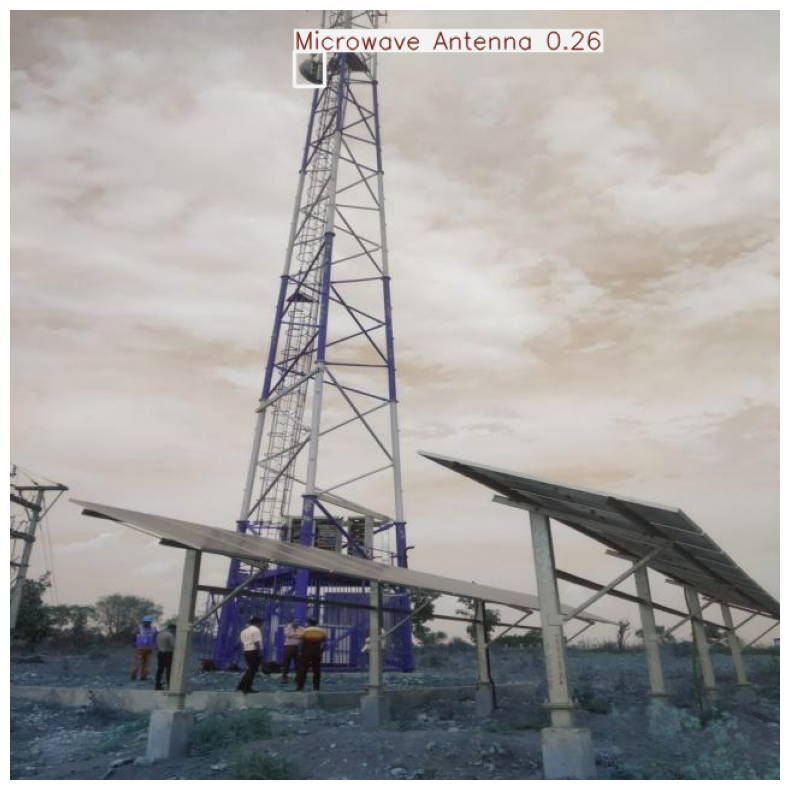

In [20]:
#Plot the show image of prediction
plt.figure(figsize=(10, 10))
plt.imshow(prediction)
plt.axis('off')
plt.show()


#Task 7: Model Export

In [ ]:
# Export model to ONNX format
model.export(format='onnx')